# Structure learning with cause2e
This notebook shows how ```cause2e``` can be used for learning causal graphs. Structure learning (also called causal discovery) can be performed by the ```discovery.StructureLearner``` after reading data and specifying domain knowledge. If we only want to perform a quick exploratory search, we can use the provided reasonable default parameters for the search procedure. However, if we need to finetune the settings for the causal search after encountering problems with the default option, this notebooks shows how to do it. The search is mostly based on the ```py-causal``` package, a wrapper around the well-known JAVA ```TETRAD``` software. ```Cause2e``` aims to use ```py-causal``` algorithms only for the search itself, in order to spare the user from dealing with JAVA error messages when dealing with peripheral tasks.

### Imports

In [17]:
import os
from cause2e import path_mgr, discovery, knowledge

## Set up paths to data and output directories
This step is conveniently handled by the ```PathManager``` class, which avoids having to wrestle with paths throughout the multistep causal analysis. If we want to perform the analysis in a directory ```'dirname'``` that contains ```'dirname/data'``` and ```'dirname/output'``` as subdirectories, we can also use ```PathManagerQuick``` for an even easier setup. The experiment name is used for generating output files with meaningful names, in case we want to study multiple scenarios (e.g. with varying model parameters). For this analysis, we use the sprinkler dataset.

In [18]:
cwd = os.getcwd()
wd = os.path.dirname(cwd)
paths = path_mgr.PathManagerQuick(experiment_name='sprinkler',
                                  data_name='sprinkler.csv',
                                  directory=wd
                                  )

## Initialize the StructureLearner
As in the other notebooks, we set up a ```StructureLearner``` and read our data.

In [19]:
learner = discovery.StructureLearner(paths)
learner.read_csv(index_col=0)

The first step in the analysis should be an assessment of which variables we are dealing with. In the sprinkler dataset, each sample tells us 
- the current season
- whether it is raining
- whether our lawn sprinkler is activated
- whether our lawn is slippery
- whether our lawn is wet.

In [20]:
print(learner.variables)

{'Rain', 'Wet', 'Slippery', 'Season', 'Sprinkler'}


It necessary to communicate to the ```StructureLearner``` if the variables are discrete, continuous, or both. We check how many unique values each variable takes on in our sample and deduce that all variables are discrete.

In [21]:
print(learner.data.nunique())

Season       4
Sprinkler    2
Rain         2
Wet          2
Slippery     2
dtype: int64


This information is passed to the ```StructureLearner``` by indicating the exact sets of discrete and continuous variables.

In [22]:
learner.discrete = set(learner.variables)
learner.continuous = set()

### Provide domain knowledge
Humans can often infer parts of the causal graph from domain knowledge. The nodes are always just the variables in the data, so the problem of finding the right graph comes down to selecting the right edges between them.

As a reminder: The correct causal graph has an edge from variable A to variable B if and only if variable A directly influences variable B (changing the value of variable A changes the value of variable B if we keep all other variables fixed).


There are three ways of passing domain knowledge:
- Indicate which edges must be present in the causal graph.
- Indicate which edges must not be present in the causal graph.
- Indicate a temporal order in which the variables have been created. This is then used to generate forbidden edges, since the future can never influence the past.

In this example, we only assume that the current season is directly influencing the weather and the probability that the sprinkler is on. This makes sense: During the summer, it is less likely to rain and sprinklers are more likely to be activated.

In [23]:
required = {('Season', 'Rain'), ('Season', 'Sprinkler')}

We pass the knowledge to the ```StructureLearner``` and check if it has been correctly received.

In [24]:
learner.set_knowledge(required=required)
print(learner.knowledge)

{'forbidden': set(), 'required': {('Season', 'Rain'), ('Season', 'Sprinkler')}, 'temporal': [], 'expected_effects': {}}


## Select and use a structure learning algorithm
Now that the ```StructureLearner``` has received the data and the domain knowledge, we can try to recover the original graph using causal discovery methods provided by the internally called ```py-causal``` package. There are many parameters that can be tuned (choice of algorithm, search score, independence test, hyperparameters, ...) and we can get an overview by calling some informative methods of the learner.

In [25]:
learner.show_search_algos()
learner.show_search_scores()
learner.show_independence_tests()

TETRAD search algos:

fas
fask
fci
fges
fges-mb
fofc
ftfc
gfci
glasso
imgs_cont
imgs_disc
ling
lingam
mbfs
mgm
multi-fask
pc-all
r-skew
r3
rfci
rfci-bsc
skew
ts-fci
ts-gfci
ts-imgs
---------------------

TETRAD search scores:

bdeu-score
cci-score
cg-bic-score
cg-other-bic-score
d-sep-score
degen-gauss-bic
disc-bic-score
disc-mixed-bic-score
mnlr-bic-score
mvp-bic-score
sem-bic
---------------------

TETRAD search independence tests:

bdeu-test
cci-test
cg-lr-test
chi-square-test
d-sep-test
dg-lr-test
disc-bic-test
fisher-z-test
g-square-test
kci-test
mnlrlr-test
mvplr-test
prob-test
---------------------



To make an informed choice, we can browse through the proposed search algorithms and decide which one fits our problem. Let us have a look at the FGES algorithm, which is a well known score-based algorithm that is suitable for a mix of continuous and discrete data. Note that it also accepts domain knowledge, which makes it a good starting point for many datasets.

In [26]:
learner.show_algo_info('fges')

FGES is an optimized and parallelized version of an algorithm developed by Meek [Meek, 1997] called the Greedy Equivalence Search (GES). The algorithm was further developed and studied by Chickering [Chickering, 2002]. GES is a Bayesian algorithm that heuristically searches the space of CBNs and returns the model with highest Bayesian score it finds. In particular, GES starts its search with the empty graph. It then performs a forward stepping search in which edges are added between nodes in order to increase the Bayesian score. This process continues until no single edge addition increases the score. Finally, it performs a backward stepping search that removes edges until no single edge removal can increase the score. More information is available here and here. The reference is Ramsey et al., 2017.
The algorithms requires a decomposable score—that is, a score that for the entire DAG model is a sum of logged scores of each variables given its parents in the model. The algorithms can t

The description tells us that we can select a search score and pass our domain knowledge. If we actually want to call the algorithm, we need to know if it requires additional hyperparameters and what they mean. These can be inspected via another utility method. Since FGES requires a score, we need to pass one to ```show_algo_params```, but it seems that the choice does not affect the output, so we just choose one at random from the above list.

In [27]:
learner.show_algo_params('fges', score_name='cg-bic-score')

faithfulnessAssumed: This is a parameter for FGES (“Fast GES”). If this is set to ‘Yes’, it will be assumed that if X _||_ Y, by an independence test, then X _||_ Y | Z for nonempty Z. If the model is faithful to the data, this will necessarily be the case. However, there are some non-faithful examples one can propose where this is not the case. If one is worried about this kind of unfaithfulness, one should set this parameter to ‘No’. If one is willing to tolerate this kind of unfaithfulness, then setting this parameter to ‘Yes’ leads to significantly faster searches. (java.lang.Boolean) [default:true]
symmetricFirstStep: For discrete searches, and in some other situations, it may make a difference for an edge X—Y whether you score X->Y or X<-Y, even though theoretically they should have the same score. If this parameter is set to “Yes”, both scores will be calculated and the higher score used. (Recall we are calculating BIC as 2L – c k ln N, where c is the penalty discount.) (java.la

Let us try out a possible search configuration.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The graph is fully directed.



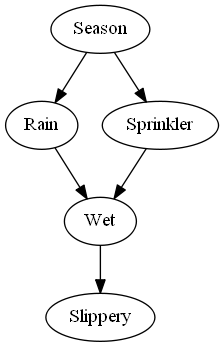

Saving dot file.
Knowledge is respected!
Saving png file.
Knowledge is respected!
Saving svg file.
Knowledge is respected!


In [28]:
learner.run_search(algo='fges', scoreId='cg-bic-score', maxDegree=5, faithfulnessAssumed=True, symmetricFirstStep=True)

The output of the search is a proposed causal graph. We can ignore the warning about stopping the Java Virtual Machine (needed by ```py-causal``` which is a wrapper around the ```TETRAD``` software that is written in Java) if we do not run into any problems. If the algorithm cannot orient all edges, we need to do this manually. Therefore, the output includes a list of all undirected edges, so we do not miss them in complicated graphs with many variables and edges. In our case, all the edges are already oriented.

The result seems reasonable:
- The weather depends on the season.
- The sprinkler use also depends on the season.
- The lawn will be wet if it rains or if the sprinkler is activated.
- The lawn will be slippery if it is wet.

We can also see that the result is automatically saved to different file formats and that our graph respects the previously indicated domain knowledge.

In order to spare users from the pain of going through all the above reading whenever they want to perform just a quick exploratory analysis, we have provided the above configuration as default arguments (FGES with CG-BIC score for possibly mixed datatypes, respecting domain knowledge, assuming faithfulness, using symmetric first step) that let us start the search without any finetuning. Just call ```run_quick_search()``` and you are good to go.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The graph is fully directed.



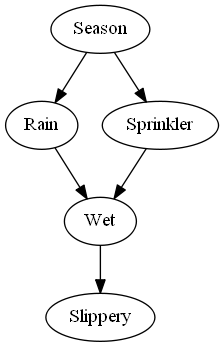

Saving dot file.
Knowledge is respected!
Saving png file.
Knowledge is respected!
Saving svg file.
Knowledge is respected!


In [29]:
learner.run_quick_search()

In this notebook we want to show how to switch to a different algorithm, e.g. a variant of the constraint-based PC algorithm, which can be found under the name ```pc-all``` in the above listing of algorithms. The procedure is the same as above, it just requires some reading of ```py-causal```'s algorithm descriptions.

In [30]:
learner.show_algo_info('pc-all')

PC algorithm (Spirtes and Glymour, Social Science Computer Review, 1991) is a pattern search which assumes that the underlying causal structure of the input data is acyclic, and that no two variables are caused by the same latent (unmeasured) variable. In addition, it is assumed that the input data set is either entirely continuous or entirely discrete; if the data set is continuous, it is assumed that the causal relation between any two variables is linear, and that the distribution of each variable is Normal. Finally, the sample should ideally be i.i.d.. Simulations show that PC and several of the other algorithms described here often succeed when these assumptions, needed to prove their correctness, do not strictly hold. The PC algorithm will sometimes output double headed edges. In the large sample limit, double headed edges in the output indicate that the adjacent variables have an unrecorded common cause, but PC tends to produce false positive double headed edges on small samples

In this case, we need to pass a ```test_name``` to ```show_algo_params``` instead of a ```score_name```. Again, we pick one at random since it does not seem to change the description.

In [31]:
learner.show_algo_params('pc-all', test_name='bdeu-test')

stableFAS: In Colombo, D., & Maathuis, M. H. (2014, Order-independent constraint-based causal structure learning, The Journal of Machine Learning Research, 15(1), 3741-3782), a modification of the adjacency search of PC was proposed that results in invariance under order permutations of the variables in the data. If this parameter is set to ‘Yes’, this version of the PC adjacency search is used. (java.lang.Boolean) [default:true]
concurrentFAS: Various versions of the PC adjacency search lend themselves to concurrent processing—that is, doing different independence tests in parallel to speed up the processing. If this parameter is set to ‘Yes’, and this option is available, it will be used. (java.lang.Boolean) [default:false]
colliderDiscoveryRule: For variants of PC, one may choose from one of three different ways for orienting colliders. One may look them up from sepsets, as in the original PC, or estimate them conservatively, as from the Conservative PC algorithm, or by choosing the

Now that we know possible configuration options, we can select a few at random and check the result.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The following edges are undirected:

Slippery --- Wet


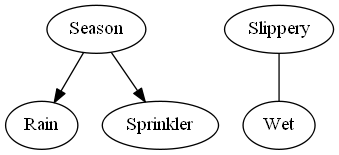

In [32]:
learner.run_search(algo='pc-all', stableFAS=True, conflictRule=1, save_graph=False)

The output is worse than the one with FGES, but the situation might be reversed for a different problem, so having the ability to quickly switch between algorithms and hyperparameters is a handy tool. Some algorithms are only suited for certain types of data, some cannot accept domain knowledge, some produce outputs that differ from the mixed graph format (other options such as PAG are currently not supported by ```cause2e```'s graph handling). Feel free to play around with different algorithms and configurations to explore the possibilities of causal discovery!